# Dependencies

In [15]:
import qgrid
import pandas as pd
from pandas import *
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
train = pd.read_csv('train.psv', sep='|')

In [31]:
sampl = pd.read_csv('./data/trainingA/p000346.psv', sep='|')
#sampl_qd = qgrid.show_grid(sampl, show_toolbar = True)
sum(sampl['SepsisLabel'])
sampl.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,70.71,1,NaN,NaN,-0.02,1,0
1,95.0,95.5,NaN,131.0,93.0,70.0,16.0,NaN,NaN,NaN,...,NaN,NaN,NaN,70.71,1,NaN,NaN,-0.02,2,0
2,88.0,96.0,NaN,NaN,89.0,NaN,18.0,NaN,NaN,NaN,...,NaN,NaN,NaN,70.71,1,NaN,NaN,-0.02,3,0
3,89.0,94.0,NaN,NaN,88.0,NaN,18.0,NaN,NaN,NaN,...,NaN,NaN,NaN,70.71,1,NaN,NaN,-0.02,4,0
4,76.0,94.0,36.72,NaN,95.0,NaN,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,70.71,1,NaN,NaN,-0.02,5,0


In [3]:
sampl.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

# Exploration

### 提取所有被判断患病的病人id

In [9]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')
list_a = []
list_b = []
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) != 0:
        list_a.append(csv)
        
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) != 0:
        list_b.append(csv)

In [10]:
list_a = sorted(list_a)
list_b = sorted(list_b)
patient_a = sorted(list(set(listdir('./data/trainingA/')) - set(list_a)))
patient_b = sorted(list(set(listdir('./data/trainingB/')) - set(list_b)))
normal_a = list_a
normal_b = list_b

##### 单个病人数据查看

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')


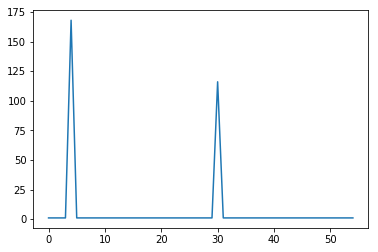

In [13]:
csv = 'p002123.psv'
print(tmp.columns)
tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
plt.plot(list(range(len(tmp))), tmp['Glucose'].fillna(1), label='broadcast')

### 正负样本比例

In [27]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

sick_A = [0, 0]

for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) > 0:
        sick_A[1] += 1
    else:
        sick_A[0] += 1
    
sick_B = [0, 0]

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) > 0:
        sick_B[1] += 1
    else:
        sick_B[0] += 1

Text(0.5, 1.0, '01 distribution for Sepsis')

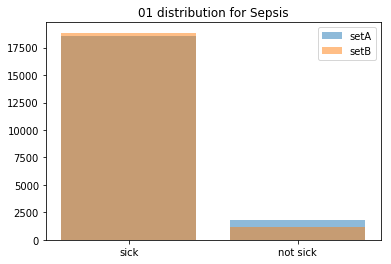

In [28]:
pA = plt.bar(['sick', 'not sick'], sick_A,label = 'line', alpha=0.5)
pB = plt.bar(['sick', 'not sick'], sick_B,label = 'line', alpha=0.5)
plt.legend(handles = [pA, pB], labels = ['setA', 'setB'], loc = 'best')
plt.title("01 distribution for Sepsis")


### 正样本分析

##### 化验数据比例

In [23]:
a_traincsv = list_a
b_traincsv = list_b

chemdata_A_sick = {}
for i in range(11):
    chemdata_A_sick[i/10] = 0
    
chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A_sick[per] += 1
    
chemdata_B_sick = {}
for i in range(11):
    chemdata_B_sick[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B_sick[per] += 1

Text(0.5, 1.0, 'laboratory data percentage in single sick person')

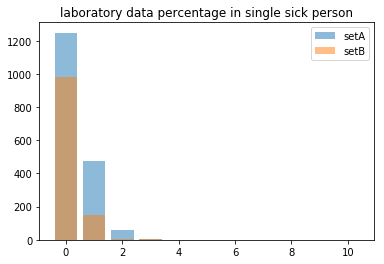

In [26]:
#chemdata_A_sick = pd.DataFrame.from_dict(chemdata_A_sick, orient='index')
#chemdata_B_sick = pd.DataFrame.from_dict(chemdata_B_sick, orient='index')
pA = plt.bar(chemdata_A_sick.index*10, chemdata_A_sick[0],label = 'line', alpha=0.5)
pB = plt.bar(chemdata_B_sick.index*10, chemdata_B_sick[0],label = 'line', alpha=0.5)
plt.legend(handles = [pA, pB], labels = ['setA', 'setB'], loc = 'best')

plt.title("laboratory data percentage in single patient")


###### 负样本对比

In [7]:
a_traincsv = list(set(listdir('./data/trainingA/')) - set(list_a))
b_traincsv = list(set(listdir('./data/trainingB/')) - set(list_b))

chemdata_A_normal = {}
for i in range(11):
    chemdata_A_normal[i/10] = 0
    
chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A_normal[per] += 1
    
chemdata_B_normal = {}
for i in range(11):
    chemdata_B_normal[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B_normal[per] += 1

Text(0.5, 1.0, 'laboratory data percentage in single normal person')

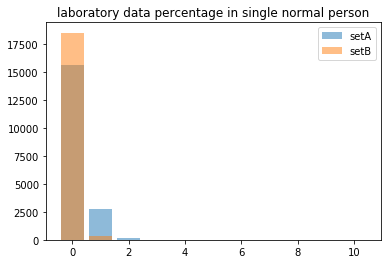

In [8]:
chemdata_A_normal = pd.DataFrame.from_dict(chemdata_A_normal, orient='index')
chemdata_B_normal = pd.DataFrame.from_dict(chemdata_B_normal, orient='index')
pA = plt.bar(chemdata_A_normal.index*10, chemdata_A_normal[0], label = 'line', alpha=0.5)
pB = plt.bar(chemdata_B_normal.index*10, chemdata_B_normal[0], label = 'line', alpha=0.5)
plt.legend(handles = [pA, pB], labels = ['setA', 'setB'], loc = 'best')

plt.title("laboratory data percentage in single normal person")


##### 生命体征分析

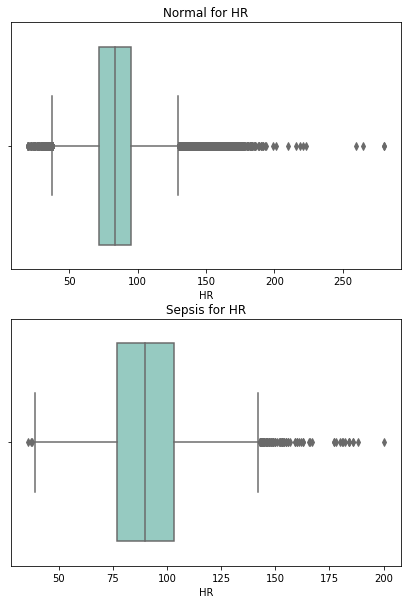

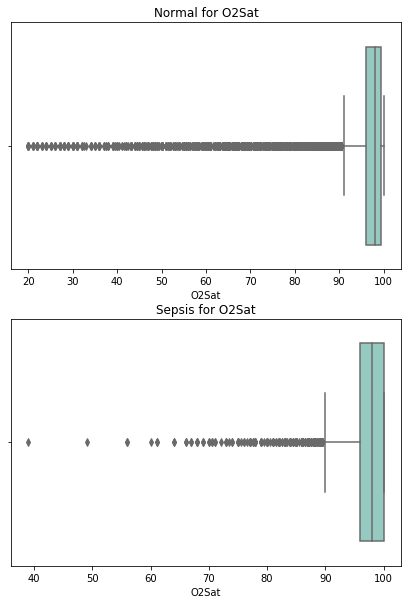

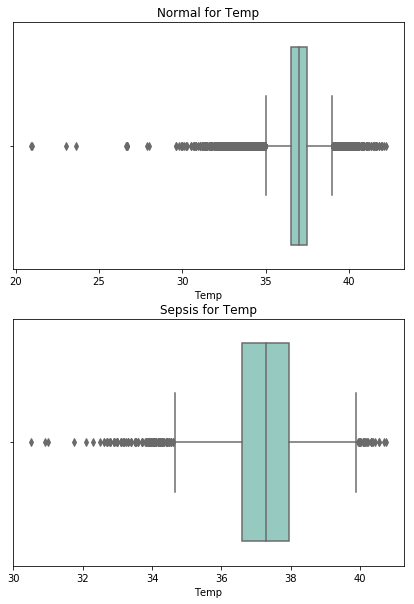

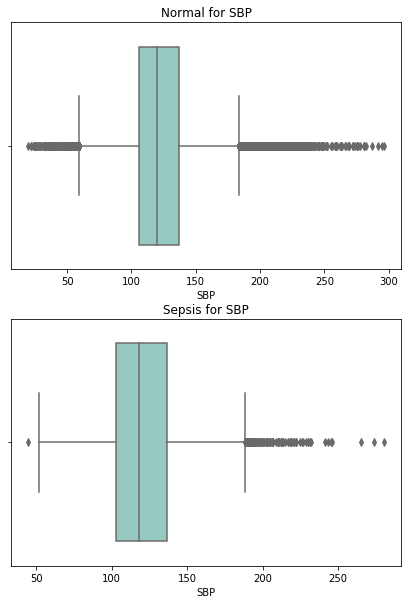

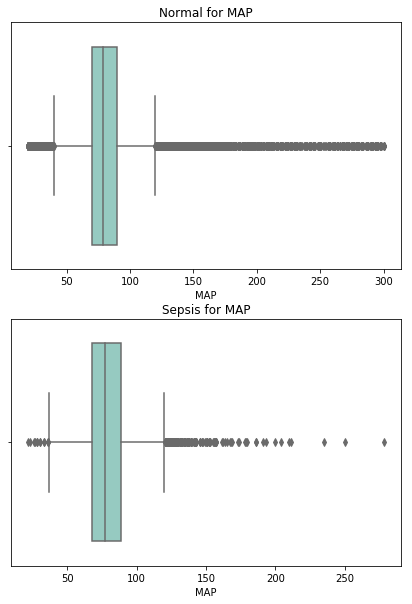

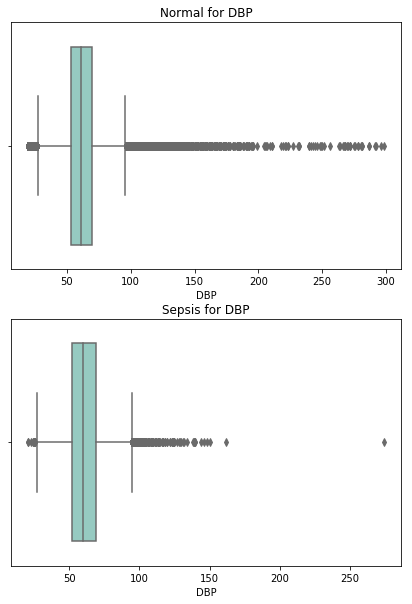

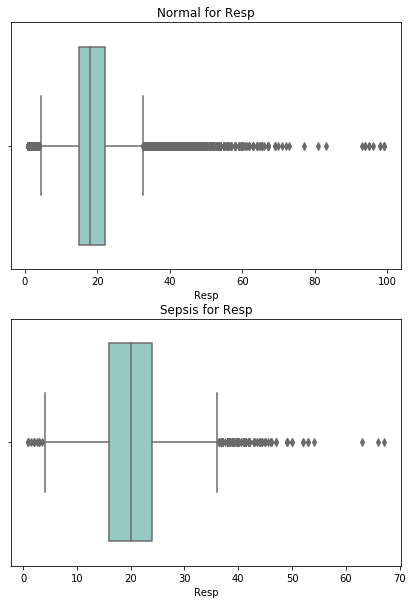

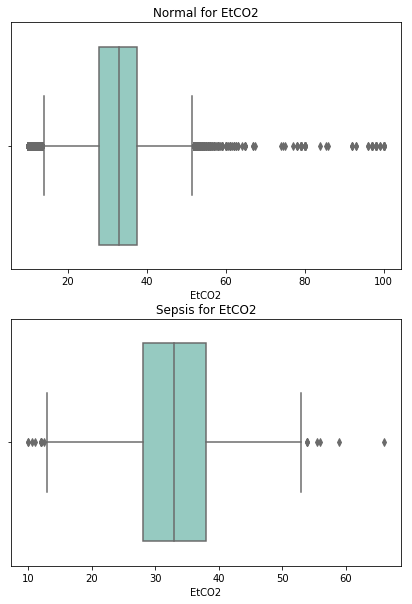

In [26]:
virtal_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
for i,var in enumerate(virtal_signs):
    temp = train[[var,'SepsisLabel']].dropna()
    temp1 = temp[temp['SepsisLabel']==0]
    temp2 = temp[temp['SepsisLabel']==1]
    fig, ax = plt.subplots(2, 1, figsize=(7, 10))

    sns.boxplot(temp1[var], ax=ax[0], palette='Set3')
    sns.boxplot(temp2[var], ax=ax[1], palette='Set3')
    ax[0].set_title("Normal for " + var)
    ax[1].set_title("Sepsis for " + var)

### 化验数据分析

##### 化验数据比例

In [7]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

chemdata_A = {}
for i in range(11):
    chemdata_A[i/10] = 0
    
chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A[per] += 1
    
chemdata_B = {}
for i in range(11):
    chemdata_B[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B[per] += 1

TypeError: unsupported operand type(s) for +: 'int' and 'str'

Text(0.5, 1.0, 'laboratory data percentage in one patient')

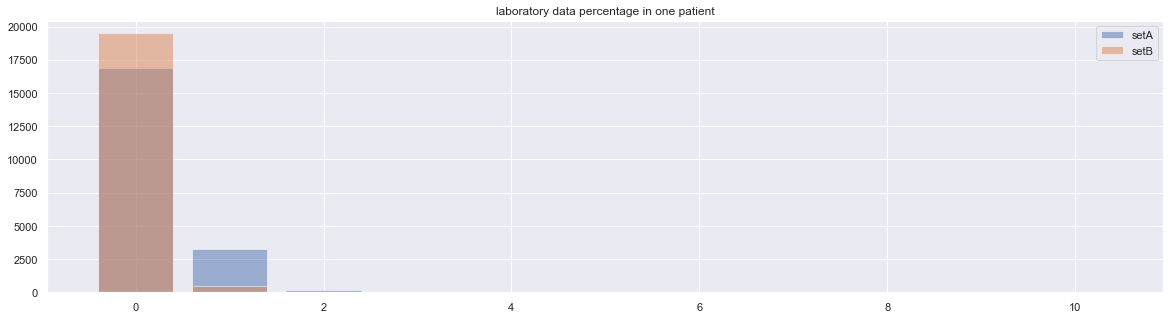

In [299]:
#chemdata_A = pd.DataFrame.from_dict(chemdata_A, orient='index')
#chemdata_B = pd.DataFrame.from_dict(chemdata_B, orient='index')
pA = plt.bar(chemdata_A.index*10, chemdata_A[0],label = 'line', alpha=0.5)
pB = plt.bar(chemdata_B.index*10, chemdata_B[0],label = 'line', alpha=0.5)
plt.legend(handles = [pA, pB], labels = ['setA', 'setB'], loc = 'best')

plt.title("laboratory data percentage in one patient")


### 单病人观察时间长度分布

In [32]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

distributionA = {}
for i in range(500):
    distributionA[i] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingA/' + csv)
    distributionA[len(tmp)] += 1
    
distributionB = {}
for i in range(500):
    distributionB[i] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingB/' + csv)
    distributionB[len(tmp)] += 1

Text(0.5, 1.0, 'length distribution of training set ')

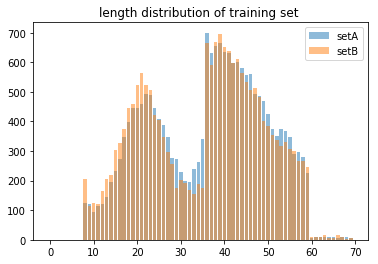

In [62]:
length_A = pd.DataFrame.from_dict(distributionA, orient='index')
length_B = pd.DataFrame.from_dict(distributionB, orient='index')
pA = plt.bar(length_A.index[:70], length_A[0][:70],label = 'line', alpha=0.5)
pB = plt.bar(length_B.index[:70], length_B[0][:70],label = 'line', alpha=0.5)
plt.legend(handles = [pA, pB], labels = ['setA', 'setB'], loc = 'best')
plt.title("length distribution of training set ")


### 单病人被判断患病的时间段占比

In [102]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

one_percentage_A = {}
for i in range(11):
    one_percentage_A[i/10] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    percentage = int(10 * sum(tmp['SepsisLabel']) / len(tmp))/10
    one_percentage_A[percentage] += 1
    
one_percentage_B = {}
for i in range(11):
    one_percentage_B[i/10] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    percentage = int(10 * sum(tmp['SepsisLabel']) / len(tmp))/10
    one_percentage_B[percentage] += 1

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, "1 label percentage in total 'SepsisLabel' for patients(10 means 100%)")

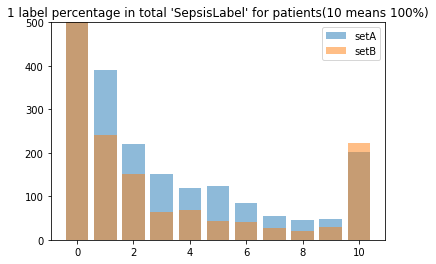

In [176]:
percentage_A = pd.DataFrame.from_dict(one_percentage_A, orient='index')
percentage_B = pd.DataFrame.from_dict(one_percentage_B, orient='index')
pA = plt.bar(percentage_A.index*10, percentage_A[0],label = 'line', alpha=0.5)
pB = plt.bar(percentage_B.index*10, percentage_B[0],label = 'line', alpha=0.5)
plt.legend(handles = [pA, pB], labels = ['setA', 'setB'], loc = 'best')

plt.ylim(ymax = 500)
plt.title("1 label percentage in total 'SepsisLabel' for patients(10 means 100%)")


### ICU种类分布

In [204]:
unit1 = 0
unit2 = 0
unit3 = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    if sum(tmp['Unit1'].fillna(0)) == len(tmp):
        unit1 += 1
    elif sum(tmp['Unit2'].fillna(0)) == len(tmp):
        unit2 += 1
    else:
        unit3 += 1
        
unit4 = 0
unit5 = 0
unit6 = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    if sum(tmp['Unit1'].fillna(0)) == len(tmp):
        unit4 += 1
    elif sum(tmp['Unit2'].fillna(0)) == len(tmp):
        unit5 += 1
    else:
        unit6 += 1

Text(0.5, 1.0, 'ICU kind distribution')

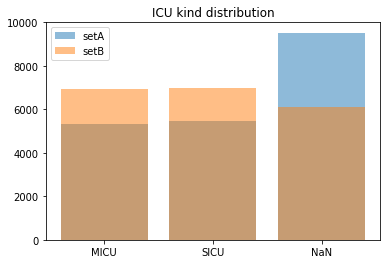

In [213]:
pA = plt.bar(['MICU','SICU','NaN'], [unit1, unit2, unit3], alpha = 0.5)
pB = plt.bar(['MICU','SICU','NaN'], [unit4, unit5, unit6], alpha = 0.5)
plt.legend(handles = [pA, pB], labels = ['setA', 'setB'], loc = 'best')

plt.title('ICU kind distribution')

### 性别分析

In [217]:
sex = [0 for _ in range(6)]
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    if sum(tmp['Gender'].fillna(-1)) == 0:
        sex[0] += 1
    elif sum(tmp['Gender'].fillna(-1)) == len(tmp):
        sex[1] += 1
    else:
        sex[2] += 1
        
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    if sum(tmp['Gender'].fillna(-1)) == 0:
        sex[3] += 1
    elif sum(tmp['Gender'].fillna(-1)) == len(tmp):
        sex[4] += 1
    else:
        sex[5] += 1

Text(0.5, 1.0, 'sex distribution')

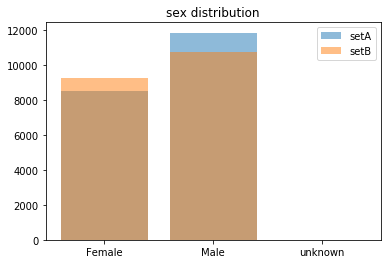

In [218]:
pA = plt.bar(['Female','Male','unknown'], sex[:3], alpha = 0.5)
pB = plt.bar(['Female','Male','unknown'], sex[3:], alpha = 0.5)
plt.legend(handles = [pA, pB], labels = ['setA', 'setB'], loc = 'best')
plt.title('sex distribution')

### 年龄分析

In [222]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

age_A = {}
for i in range(120):
    age_A[i] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    age = int(tmp['Age'][2])
    age_A[age] += 1
    
age_B = {}
for i in range(120):
    age_B[i] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    age = int(tmp['Age'][2])
    age_B[age] += 1

Text(0.5, 1.0, 'age distribution')

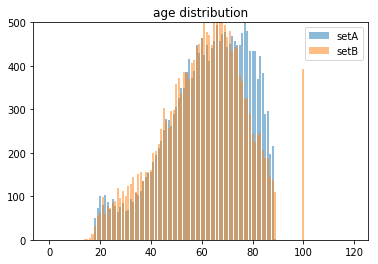

In [223]:
age_A = pd.DataFrame.from_dict(age_A, orient='index')
age_B = pd.DataFrame.from_dict(age_B, orient='index')
pA = plt.bar(age_A.index, age_A[0],label = 'line', alpha=0.5)
pB = plt.bar(age_B.index, age_B[0],label = 'line', alpha=0.5)
plt.legend(handles = [pA, pB], labels = ['setA', 'setB'], loc = 'best')

plt.ylim(ymax = 500)
plt.title("age distribution")


### 缺失度分析

In [239]:
train = pd.read_csv('./train.psv', sep = '|')
train.shape

(1170446, 41)

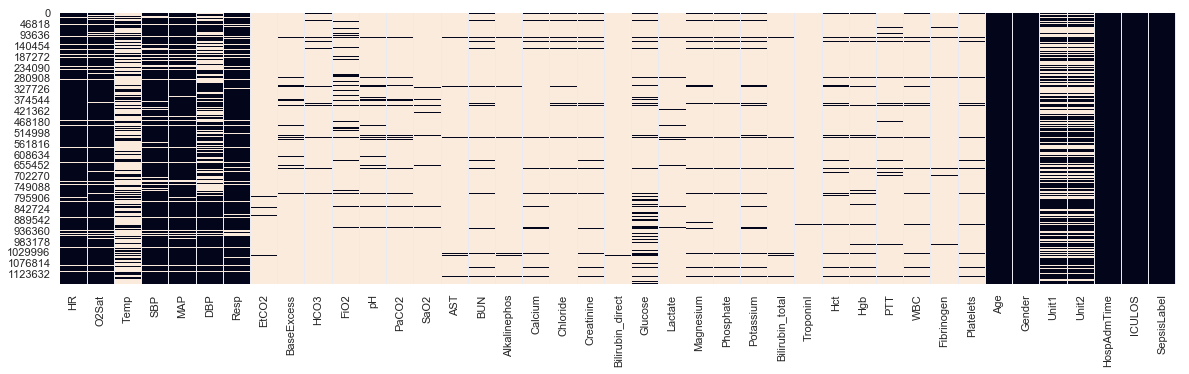

In [244]:
sns.set(rc={'figure.figsize':(20,5)})
sns.heatmap(train.isnull(), cbar=False)


# Data processing